<a href="https://colab.research.google.com/github/ArunAravind2001/GAN/blob/main/GAN_on_Fashion_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import torch.nn as nn
import torch
from torch.utils.data.dataloader import DataLoader
import torchvision.datasets as datasets
import torchvision
from torchvision import transforms as T
import matplotlib.pyplot as plt
import PIL.Image as Image
import torch.functional as F
import pandas as pd
from torchvision.utils import make_grid

In [ ]:

transforms= T.Compose([
     T.ToTensor(),
     T.Normalize((0.5,), (0.5))
])

data_mnist= datasets.FashionMNIST(root='.', train=True, transform=transforms, download=True)

batch_size =32
train_loader = DataLoader(dataset= data_mnist, batch_size =batch_size, shuffle= True)

In [ ]:
import torch
import torch.nn as nn

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.flat = nn.Flatten()
        self.dis_model = nn.Sequential(
            # 1st layer
            nn.Linear(784, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            # 2nd Layer
            nn.Linear(1024, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            # 3rd Layer
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            # 4th Layer
            nn.Linear(512, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.flat(x)
        out = self.dis_model(x)
        return out


In [ ]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
discriminate=Discriminator().to(device)

### Generator model

In [ ]:
import torch
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.gen_model = nn.Sequential(
            # 1st layer: Takes input of size 100 (noise vector)
            nn.Linear(100, 256),  # 100-dimensional input, 256-dimensional output
            nn.ReLU(),
            nn.BatchNorm1d(256),

            # 2nd Layer: Takes input of size 256, outputs size 512
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),

            # 3rd Layer: Takes input of size 512, outputs size 1024
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),

            # 4th Layer: Takes input of size 1024, outputs size 784
            nn.Linear(1024, 784),  # 784 is the flattened size of a 28x28 image
            nn.Tanh()  # Activation function to scale output to [-1, 1]
        )

    def forward(self, x):
        out = self.gen_model(x)
        out = out.view(x.size(0), 1, 28, 28)  # Reshape to a 1x28x28 image
        return out


In [ ]:
generator =Generator().to(device)

In [ ]:
lr=0.0001
epochs=50
loss_function =nn.BCELoss()

optim_gen= torch.optim.Adam(generator.parameters(), lr=lr)
optim_dis= torch.optim.Adam(discriminate.parameters(), lr=lr)

In [ ]:
for epoch in range(epochs):

  for n, (input_data, labels) in enumerate(train_loader):

    input_data =input_data.to(device)

    # create ones for labels of the discriminator i.e. binary 1 for real 0 for fake
    input_labels=torch.ones((batch_size,1)).to(device)

    #create noise as the input data for the first instance

    noise = torch.randn((batch_size, 100)).to(device)
    fake_labels=torch.zeros((batch_size,1)).to(device)

    # Put noise into the generator
    generated_data =  generator(noise)

    #combine real and fake samples and labels for training

    all_data = torch.cat((input_data, generated_data))
    all_labels= torch.cat((input_labels, fake_labels))

    #Training the discriminator
    discriminate.zero_grad()

    discriminate_output=discriminate(all_data)
    loss_discrminate = loss_function(discriminate_output, all_labels)

    loss_discrminate.backward()
    optim_dis.step()

    #data for the generator
    noise = torch.randn((batch_size, 100)).to(device)

    #Training the generrator
    generator.zero_grad()

    generated_output =generator(noise)
    dis_gen_output=discriminate(generated_output)
    loss_generate=loss_function(dis_gen_output, input_labels)

    loss_generate.backward()
    optim_gen.step()

    #print loss

    if n== batch_size-1:

      print(f'Epoch: {epoch+1} Loss Dis: {loss_discrminate}')
      print(f'Epoch: {epoch+1} Loss Gen: {loss_generate}')

Epoch: 1 Loss Dis: 0.10732899606227875
Epoch: 1 Loss Gen: 1.8535618782043457
Epoch: 2 Loss Dis: 0.38277485966682434
Epoch: 2 Loss Gen: 2.524930238723755
Epoch: 3 Loss Dis: 0.4416730999946594
Epoch: 3 Loss Gen: 1.68082594871521
Epoch: 4 Loss Dis: 0.4442204535007477
Epoch: 4 Loss Gen: 1.6181344985961914
Epoch: 5 Loss Dis: 0.6470259428024292
Epoch: 5 Loss Gen: 1.1311225891113281
Epoch: 6 Loss Dis: 0.5812067985534668
Epoch: 6 Loss Gen: 1.114122986793518
Epoch: 7 Loss Dis: 0.45224058628082275
Epoch: 7 Loss Gen: 0.9959838390350342
Epoch: 8 Loss Dis: 0.5696951150894165
Epoch: 8 Loss Gen: 1.2607667446136475
Epoch: 9 Loss Dis: 0.5837769508361816
Epoch: 9 Loss Gen: 1.148874044418335
Epoch: 10 Loss Dis: 0.581055760383606
Epoch: 10 Loss Gen: 1.099936842918396
Epoch: 11 Loss Dis: 0.660728931427002
Epoch: 11 Loss Gen: 0.8643341064453125
Epoch: 12 Loss Dis: 0.6081430912017822
Epoch: 12 Loss Gen: 0.9915210604667664
Epoch: 13 Loss Dis: 0.5854261517524719
Epoch: 13 Loss Gen: 0.8600217700004578
Epoch: 14

In [ ]:
noise= torch.randn((batch_size , 100)).to(device)
generated_data = generator(noise)

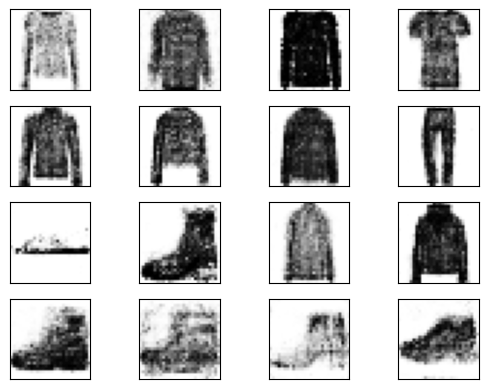

In [ ]:
generated_data = generated_data.cpu().detach()

for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(generated_data[i].squeeze(), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])